# Reduction of science images

This tutorial will use observations from the telescope Campus Observatory Garching using the instrument Generic Off-the-shelf Wide Field Imager (GOWI).

**Steps of reduction:** (see manual)
- Organize data
- Bias subtraction
- Dark correction
- Flat-field correction
- Coaddition
- Astrometry and photometry

The zip file contains all the FITS file needed for this reduction tutorial. You should extract it all in one folder and change the path to your path.

**Go step by step. Don't run it everything at once.**

_____________________________

**Important information**

This pipeline is a basic reduction, and it shows you the steps to follow for the reduction of images. The final image could be improved by including different parameters in each step, viewing the images before, and selecting the right ones.

You can modify this pipeline as you like if you want to improve the reduction. You can see in Python what extra parameters can be added to each class.

# Organize data

The first step is to move into folders the calibrations and science files that are going to be use in processing.

As a first example, lets read one FITS image to see what it contains and how we can separate it:

In [1]:
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
import os
import warnings; warnings.simplefilter('ignore')
from matplotlib.colors import Normalize, LogNorm

# path = './Data/Data/' # Path were the images are

OBJECT_CHOICE = 'M37'

if OBJECT_CHOICE == 'M57':
    path = './Data/2022-10-25_only_M57/'
    image_name = 'COG_515175_M57_00_M 57_00__02_2022_10_25_17_33_26.fits' # Name of one FITS file

elif OBJECT_CHOICE == 'M27':
    print("WARNING: will not run all the way to the end due to missing Luminance calibration files.")
    path = './Data/2022-10-25_only_M27/'
    image_name = 'COG_515196_M27_00_M 27_00__02_2022_10_25_18_04_33.fits' # Name of one FITS file

elif OBJECT_CHOICE == 'M36':
    path = './Data/2023_02_08_only_M36_original copie/'
    image_name = 'M36-g1.fits' # Name of one FITS file

elif OBJECT_CHOICE == 'M37':
    path = './Data/2023_02_XX_M37_original copie/'
    image_name = 'M37-g1.fits' # Name of one FITS file

hdu = fits.open(path+image_name)
hdu.info()

Filename: ./Data/2023_02_XX_M37_original copie/M37-g1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (4096, 4096)   int16 (rescales to uint16)   


The hdu is opening **one** FITS that contains the image header (1) and data (2)

In [2]:
header = hdu[0].header # (1) header of the FITS
hdu[0].header

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 4096 /fastest changing axis                           
NAXIS2  =                 4096 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2023-02-08T18:54:45' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   20.000000000000000 /Exposure time in seconds                        
EXPOSURE=   20.000000000000000 /Exposure time in seconds                        
CCD-TEMP=  -10.062500000000000 /CCD temperature at start of exposure in C       
XPIXSZ  =   9.0000000000000000 /Pixel Width in microns (after binning)          
YPIXSZ  =   9.00000000000000

In [3]:
data = hdu[0].data
hdu[0].data  # This will show the data 

array([[1086, 1154, 1120, ..., 1111, 1155, 1134],
       [1093, 1123, 1106, ..., 1196, 1179, 1153],
       [1118, 1141, 1139, ..., 1137, 1144, 1131],
       ...,
       [1115, 1126, 1141, ..., 1144, 1166, 1167],
       [1101, 1130, 1105, ..., 1172, 1178, 1185],
       [1114, 1127, 1116, ..., 1136, 1155, 1181]], dtype=uint16)

**To plot the image:**

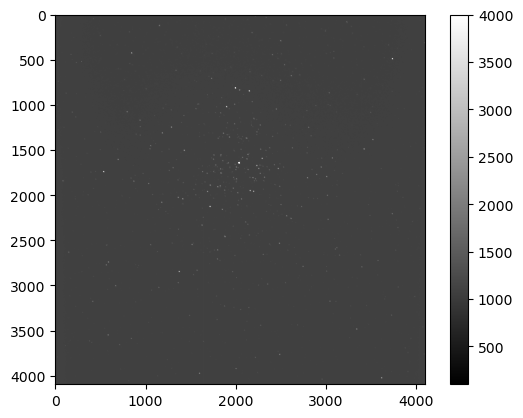

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure()
plt.imshow(data, cmap='gray',vmin=100, vmax=4000)
plt.colorbar()

In [5]:
hdu.close()

This was an example for one image, what happens with many images? 

**One easy way to organize the data is to create folders for each type of images. To do this we can use ImageFileCollection from ccdproc, an astropy affiliated package for data reduction.**

This will show us a summary of the images:

In [6]:
from ccdproc import ImageFileCollection

images = ImageFileCollection(path)
images.summary

<Table masked=True length=78>
                       file                       simple ...    swowner   
                      str51                        bool  ...     object   
------------------------------------------------- ------ ... -------------
     COG_554267_Bias11_1_2023_02_08_16_08_30.fits   True ...            --
     COG_554268_Bias11_2_2023_02_08_16_08_50.fits   True ...            --
     COG_554269_Bias11_3_2023_02_08_16_09_09.fits   True ...            --
     COG_554270_Bias11_4_2023_02_08_16_09_29.fits   True ...            --
     COG_554271_Bias11_5_2023_02_08_16_09_49.fits   True ...            --
     COG_554272_Bias11_6_2023_02_08_16_10_09.fits   True ...            --
COG_554287_flats_Blue_03_2023_02_08_16_30_22.fits   True ...            --
COG_554288_flats_Blue_02_2023_02_08_16_31_08.fits   True ...            --
COG_554289_flats_Blue_01_2023_02_08_16_34_51.fits   True ...            --
COG_554290_flats_Blue_00_2023_02_08_16_35_38.fits   True ...            --
                                              ...    ... ...           ...
                                   dark_20_1.fits   True ... Vadim Burwitz
                                  dark_20_10.fits   True ... Vadim Burwitz
                                   dark_20_2.fits   True ... Vadim Burwitz
                                   dark_20_3.fits   True ... Vadim Burwitz
                                   dark_20_4.fits   True ... Vadim Burwitz
                                   dark_20_5.fits   True ... Vadim Burwitz
                                   dark_20_6.fits   True ... Vadim Burwitz
                                   dark_20_7.fits   True ... Vadim Burwitz
                                   dark_20_8.fits   True ... Vadim Burwitz
                                   dark_20_9.fits   True ... Vadim Burwitz

In [7]:
#Create an image file collection with the keys:

keys = ['imagetyp','object','exptime','filter']
allimages = ImageFileCollection(path, keywords=keys)
allimages.summary

<Table masked=True length=78>
                       file                        imagetyp  ... exptime filter
                      str51                         str11    ... float64 object
------------------------------------------------- ---------- ... ------- ------
     COG_554267_Bias11_1_2023_02_08_16_08_30.fits       Bias ...     0.0 Halpha
     COG_554268_Bias11_2_2023_02_08_16_08_50.fits       Bias ...     0.0 Halpha
     COG_554269_Bias11_3_2023_02_08_16_09_09.fits       Bias ...     0.0 Halpha
     COG_554270_Bias11_4_2023_02_08_16_09_29.fits       Bias ...     0.0 Halpha
     COG_554271_Bias11_5_2023_02_08_16_09_49.fits       Bias ...     0.0 Halpha
     COG_554272_Bias11_6_2023_02_08_16_10_09.fits       Bias ...     0.0 Halpha
COG_554287_flats_Blue_03_2023_02_08_16_30_22.fits       Flat ...    0.05   Blue
COG_554288_flats_Blue_02_2023_02_08_16_31_08.fits       Flat ...     2.0   Blue
COG_554289_flats_Blue_01_2023_02_08_16_34_51.fits       Flat ...     0.2   Blue
COG_554290_flats_Blue_00_2023_02_08_16_35_38.fits       Flat ...     2.0   Blue
                                              ...        ... ...     ...    ...
                                   dark_20_1.fits Dark Frame ...    20.0     --
                                  dark_20_10.fits Dark Frame ...    20.0     --
                                   dark_20_2.fits Dark Frame ...    20.0     --
                                   dark_20_3.fits Dark Frame ...    20.0     --
                                   dark_20_4.fits Dark Frame ...    20.0     --
                                   dark_20_5.fits Dark Frame ...    20.0     --
                                   dark_20_6.fits Dark Frame ...    20.0     --
                                   dark_20_7.fits Dark Frame ...    20.0     --
                                   dark_20_8.fits Dark Frame ...    20.0     --
                                   dark_20_9.fits Dark Frame ...    20.0     --

**As you can see, there are images that are Bias, Flats, Darks and Object**

In [8]:
# List of science images
if OBJECT_CHOICE in ('M57', 'M27'):
    science_imagetyp = 'Object'
    flat_imagetyp = 'Flat'
    bias_imagetyp = 'Bias'
    dark_imagetyp = 'Dark'
elif OBJECT_CHOICE in ('M36', 'M37'):
    science_imagetyp = 'Light Frame'
    flat_imagetyp = 'Flat'
    bias_imagetyp = 'Bias'
    dark_imagetyp = 'Dark Frame'

sciencelist = allimages.files_filtered(imagetyp=science_imagetyp)
print(sciencelist)

['M37-b1.fits' 'M37-b2.fits' 'M37-b3.fits' 'M37-b4.fits' 'M37-b5.fits'
 'M37-g1.fits' 'M37-g2.fits' 'M37-g3.fits' 'M37-g4.fits' 'M37-g5.fits'
 'M37-r1.fits' 'M37-r2.fits' 'M37-r3.fits' 'M37-r4.fits' 'M37-r5.fits']


# Create a folder for each calibration

In [9]:
from pathlib import Path

#Bias

Bias_data = Path(path, 'Bias')  
Bias_data.mkdir(exist_ok=True) 

biases = allimages.files_filtered(imagetyp=bias_imagetyp, include_path=True)
print(biases)

import shutil

for bias in biases:
    shutil.move(bias, Bias_data)

['./Data/2023_02_XX_M37_original copie/COG_554267_Bias11_1_2023_02_08_16_08_30.fits', './Data/2023_02_XX_M37_original copie/COG_554268_Bias11_2_2023_02_08_16_08_50.fits', './Data/2023_02_XX_M37_original copie/COG_554269_Bias11_3_2023_02_08_16_09_09.fits', './Data/2023_02_XX_M37_original copie/COG_554270_Bias11_4_2023_02_08_16_09_29.fits', './Data/2023_02_XX_M37_original copie/COG_554271_Bias11_5_2023_02_08_16_09_49.fits', './Data/2023_02_XX_M37_original copie/COG_554272_Bias11_6_2023_02_08_16_10_09.fits']


In [10]:
#Dark

Dark_data = Path(path, 'Dark')  
Dark_data.mkdir(exist_ok=True) 

darks = allimages.files_filtered(imagetyp=dark_imagetyp, include_path=True)

for dark in darks:
    shutil.move(dark, Dark_data)

In [11]:
# Flats

Flat_data = Path(path, 'Flats')  
Flat_data.mkdir(exist_ok=True) 

flats = allimages.files_filtered(imagetyp=flat_imagetyp, include_path=True)

for flat in flats:
    shutil.move(flat, Flat_data)

In [12]:
# Science images

img_data = Path(path, 'Object')  
img_data.mkdir(exist_ok=True) 

imgs = allimages.files_filtered(imagetyp=science_imagetyp, include_path=True)

for img in imgs:
    shutil.move(img, img_data)

# Create master bias frame

In [13]:
bias_folder = ImageFileCollection(path+'Bias') #showing all the bias images in this folder
bias_folder.summary

<Table masked=True length=6>
                    file                     simple bitpix ... xorgsubf yorgsubf
                   str44                      bool  int64  ...  object   object 
-------------------------------------------- ------ ------ ... -------- --------
COG_554267_Bias11_1_2023_02_08_16_08_30.fits   True     16 ...       --       --
COG_554268_Bias11_2_2023_02_08_16_08_50.fits   True     16 ...       --       --
COG_554269_Bias11_3_2023_02_08_16_09_09.fits   True     16 ...       --       --
COG_554270_Bias11_4_2023_02_08_16_09_29.fits   True     16 ...       --       --
COG_554271_Bias11_5_2023_02_08_16_09_49.fits   True     16 ...       --       --
COG_554272_Bias11_6_2023_02_08_16_10_09.fits   True     16 ...        1        1

In [14]:
from astropy.nddata import CCDData
from astropy.stats import mad_std
import ccdproc as ccdp

calibrated_path = Path(path+'Bias')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

calibrated_biases = reduced_images.files_filtered(imagetyp=bias_imagetyp, include_path=True)

combined_bias = ccdp.combine(calibrated_biases, method='average', unit='adu')

combined_bias.meta['combined'] = True

combined_bias.write(calibrated_path / 'combined_bias_2.fit') #name of bias master 


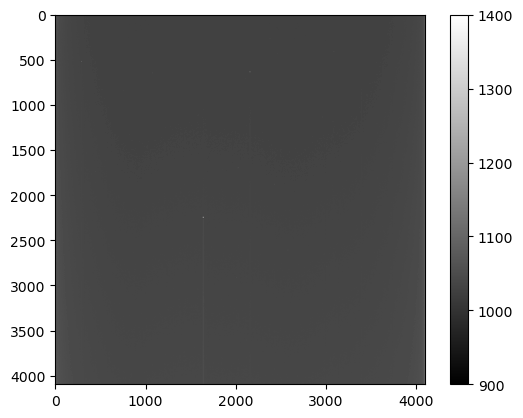

In [15]:
## see combined BIAS image
image_name_bias = 'combined_bias_2.fit' # Name of the FITS file
comb_bias = fits.open(path+'Bias/'+image_name_bias)
data_bias=comb_bias[0].data

plt.figure()
plt.imshow(data_bias, cmap='gray',vmin=900, vmax=1400)
plt.colorbar()

# Create master Dark

In [16]:
# First see that the time exposure are the same for the science images and the Darks

path_images = Path(path+'Object/')
path_darks = Path(path+'Dark/')

images_raw = ImageFileCollection(path_images)
darks_raw = ImageFileCollection(path_darks)

In [17]:
images_raw.summary['file', 'imagetyp', 'exptime', 'filter']

<Table length=15>
    file      imagetyp  exptime filter
   str11       str11    float64  str5 
----------- ----------- ------- ------
M37-b1.fits Light Frame    20.0   Blue
M37-b2.fits Light Frame    20.0   Blue
M37-b3.fits Light Frame    20.0   Blue
M37-b4.fits Light Frame    20.0   Blue
M37-b5.fits Light Frame    20.0   Blue
M37-g1.fits Light Frame    20.0  Green
M37-g2.fits Light Frame    20.0  Green
M37-g3.fits Light Frame    20.0  Green
M37-g4.fits Light Frame    20.0  Green
M37-g5.fits Light Frame    20.0  Green
M37-r1.fits Light Frame    20.0    Red
M37-r2.fits Light Frame    20.0    Red
M37-r3.fits Light Frame    20.0    Red
M37-r4.fits Light Frame    20.0    Red
M37-r5.fits Light Frame    20.0    Red

In [18]:
darks_raw.summary['file', 'imagetyp', 'exptime']

<Table length=10>
      file       imagetyp  exptime
     str15        str10    float64
--------------- ---------- -------
 dark_20_1.fits Dark Frame    20.0
dark_20_10.fits Dark Frame    20.0
 dark_20_2.fits Dark Frame    20.0
 dark_20_3.fits Dark Frame    20.0
 dark_20_4.fits Dark Frame    20.0
 dark_20_5.fits Dark Frame    20.0
 dark_20_6.fits Dark Frame    20.0
 dark_20_7.fits Dark Frame    20.0
 dark_20_8.fits Dark Frame    20.0
 dark_20_9.fits Dark Frame    20.0

In [19]:
dark_exptime = set(darks_raw.summary['exptime'])
print(dark_exptime)
#print(darks_raw.summary['file'])

{20.0}


In [20]:
# Search for the combined bias 
combined_bias = CCDData.read(path+'Bias/'+image_name_bias)

darks_1 = darks_raw.files_filtered(imagetyp=dark_imagetyp)
combined_Dark=0

# subtract bias from the darks and save them as Darks_X.fits
for j in range(0,len(darks_1)):
    combined_Dark = CCDData.read(path+'Dark/'+darks_1[j], unit='adu')
    ccd = ccdp.subtract_bias(combined_Dark, combined_bias)
    name = 'Darks_{id}.fits'.format(id=j)
    Dark_calcomb = Path(path, 'Dark_combined')  
    Dark_calcomb.mkdir(exist_ok=True) 
    ccd.write(Dark_calcomb / name,overwrite=True)

In [21]:
#  see the Darks created
darks_comb = ImageFileCollection(Dark_calcomb)
calibrated_darks = darks_comb.files_filtered(imagetyp='Dark', include_path=True)
dark_exptime = set(darks_comb.summary['exptime'])
path_comb=Path(path, 'Dark_combined')
darks_comb.summary['file', 'imagetyp', 'exptime'] #, 'filter']

<Table length=10>
    file      imagetyp  exptime
   str12       str10    float64
------------ ---------- -------
Darks_0.fits Dark Frame    20.0
Darks_1.fits Dark Frame    20.0
Darks_2.fits Dark Frame    20.0
Darks_3.fits Dark Frame    20.0
Darks_4.fits Dark Frame    20.0
Darks_5.fits Dark Frame    20.0
Darks_6.fits Dark Frame    20.0
Darks_7.fits Dark Frame    20.0
Darks_8.fits Dark Frame    20.0
Darks_9.fits Dark Frame    20.0

In [22]:
import math

for exp_time in sorted(dark_exptime):
    calibrated_darks = darks_comb.files_filtered(imagetyp=dark_imagetyp, exptime=exp_time, include_path=True)

    combined_dark = ccdp.combine(calibrated_darks,
                                 method='average',unit='adu')
    combined_dark.meta['combined'] = True
    dark_file_name = 'combined_dark.fits'
    combined_dark.write(path_comb / dark_file_name)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


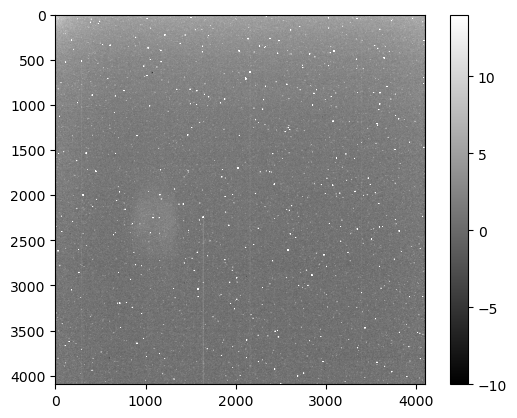

In [23]:
## see Dark combine
image_name_dark = 'combined_dark.fits' # Name of the FITS file

comb_dark = fits.open(path+'Dark_combined/'+image_name_dark) # Name of the dark  file

data_dark=comb_dark[0].data

plt.figure()
plt.imshow(data_dark, cmap='gray',vmin=-10, vmax=14)
plt.colorbar()

Text(0.5, 1.0, '10 Combined dark images with bias extracted')

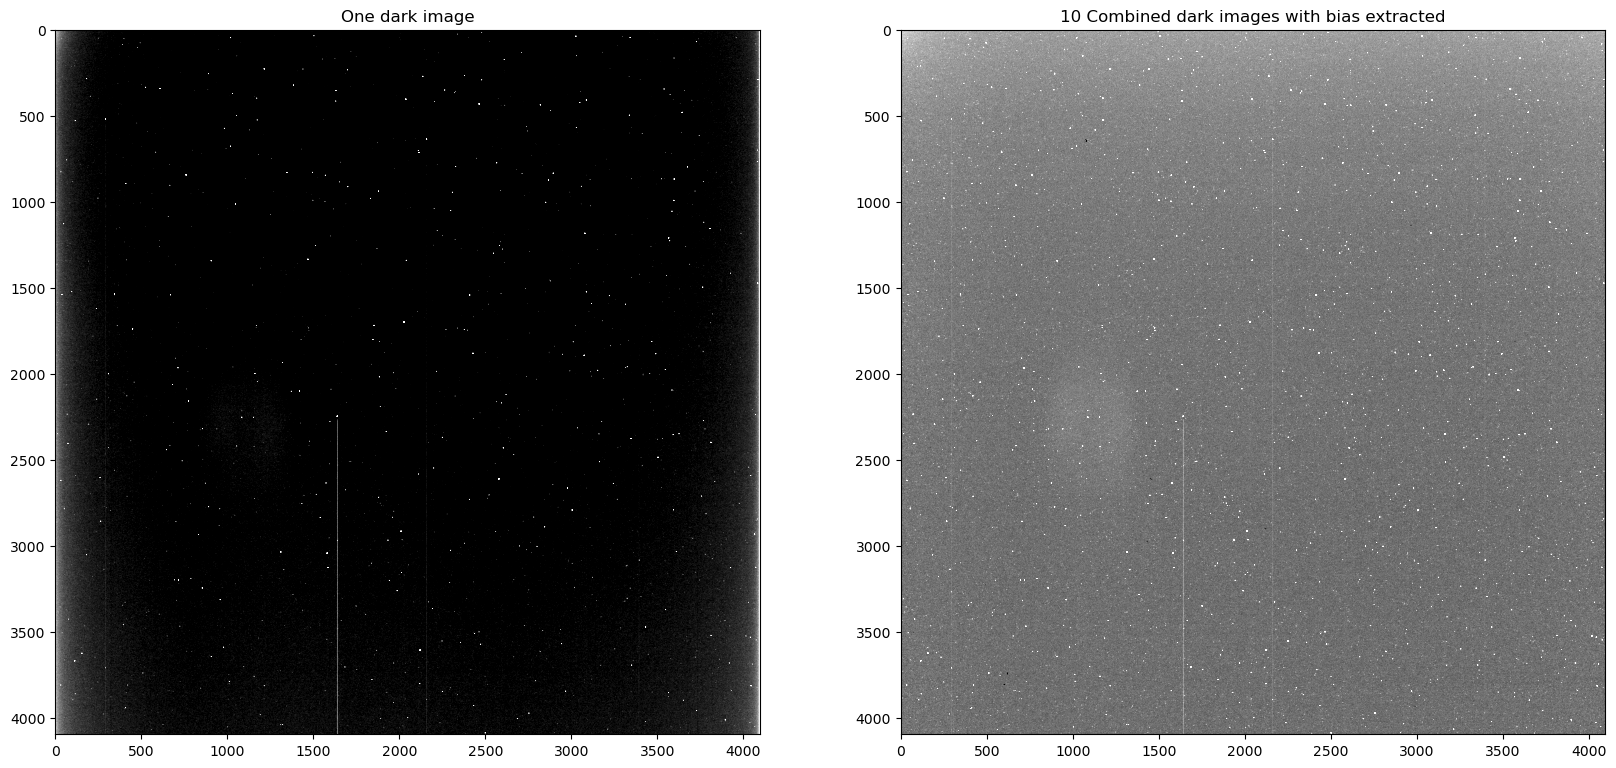

In [24]:
# Difference between one Dark and the combined non-vias Dark:
from astropy.nddata import CCDData

fig, ax_arr = plt.subplots(1, 2, figsize=(20, 10))

ax_arr[0].imshow(CCDData.read(path+'Dark/'+darks_1[0], unit='adu').data, cmap='gray',vmin=1037.75, vmax=1093.37)
ax_arr[0].set_title('One dark image')
ax_arr[1].imshow(comb_dark[0].data, cmap='gray',vmin=-10, vmax=14)
ax_arr[1].set_title('{} Combined dark images with bias extracted'.format(len(calibrated_darks)))

# Create master Flat

In [28]:
# See Flats

path_Flats = Path(path+'Flats/')
flats_raw = ImageFileCollection(path_Flats)

flats_raw.summary['file', 'imagetyp', 'exptime', 'filter']

<Table length=38>
                       file                        imagetyp exptime filter
                      str50                          str4   float64  str5 
-------------------------------------------------- -------- ------- ------
 COG_554287_flats_Blue_03_2023_02_08_16_30_22.fits     Flat    0.05   Blue
 COG_554288_flats_Blue_02_2023_02_08_16_31_08.fits     Flat     2.0   Blue
 COG_554289_flats_Blue_01_2023_02_08_16_34_51.fits     Flat     0.2   Blue
 COG_554290_flats_Blue_00_2023_02_08_16_35_38.fits     Flat     2.0   Blue
COG_554295_flats_Green_03_2023_02_08_16_43_59.fits     Flat    0.05  Green
COG_554296_flats_Green_02_2023_02_08_16_44_43.fits     Flat     2.0  Green
COG_554297_flats_Green_01_2023_02_08_16_45_10.fits     Flat    5.51  Green
COG_554298_flats_Green_00_2023_02_08_16_45_39.fits     Flat    6.41  Green
  COG_554299_flats_Red_04_2023_02_08_16_46_52.fits     Flat    0.05    Red
  COG_554300_flats_Red_03_2023_02_08_16_47_34.fits     Flat     2.0    Red
                                               ...      ...     ...    ...
  COG_555003_flats_Red_02_2023_02_10_06_09_35.fits     Flat    3.68    Red
  COG_555004_flats_Red_01_2023_02_10_06_10_02.fits     Flat    3.48    Red
  COG_555005_flats_Red_00_2023_02_10_06_10_47.fits     Flat    3.17    Red
COG_555006_flats_Green_04_2023_02_10_06_11_51.fits     Flat    0.05  Green
COG_555007_flats_Green_03_2023_02_10_06_12_16.fits     Flat     2.0  Green
COG_555008_flats_Green_02_2023_02_10_06_12_42.fits     Flat    2.46  Green
COG_555009_flats_Green_01_2023_02_10_06_13_26.fits     Flat    2.29  Green
COG_555010_flats_Green_00_2023_02_10_06_14_10.fits     Flat    2.01  Green
 COG_555012_flats_Blue_03_2023_02_10_06_20_17.fits     Flat    0.05   Blue
 COG_555013_flats_Blue_02_2023_02_10_06_21_01.fits     Flat     2.0   Blue

In [29]:
# See filters available
flat_filters = set(h['filter'] for h in flats_raw.headers(imagetyp='Flat'))
flat_filters

{'Blue', 'Green', 'Red'}

**Before creating the master flats, we need to make sure that none of the images are saturated.**

To verify this, we can create a median and mean of the counts for each Flats image:

[13989.0, 65535.0, 8686.0, 65025.0, 2189.0, 11613.0, 27448.0, 28778.0, 1817.0, 8279.0, 26346.0, 28307.0, 26828.0, 8335.0, 65535.0, 5598.0, 39657.0, 1689.0, 7106.0, 25785.0, 28247.0, 1397.0, 4396.0, 22820.0, 26318.0, 20890.0, 2370.0, 17417.0, 33875.0, 35187.0, 37047.0, 3242.0, 26071.0, 34393.0, 36582.0, 36788.0, 12542.0, 65535.0]


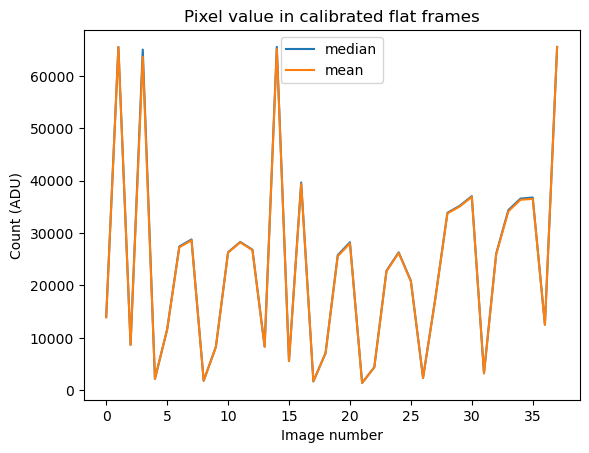

In [30]:
median_count = [np.median(data) for data in flats_raw.data(imagetyp='Flat')]
mean_count = [np.mean(data) for data in flats_raw.data(imagetyp='Flat')]
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image number')
plt.ylabel('Count (ADU)')
plt.title('Pixel value in calibrated flat frames')
plt.legend()
print(median_count)

This plots tell us that from the 14 images listed in the flats list, there are two that have counts > 60.000, meaning that they are saturated. We can observe a comparison of a non-saturated and a saturated Flat in the next figure:

FileNotFoundError: [Errno 2] No such file or directory: './Data/2023_02_08_only_M37_original copie/Flats/COG_515151_flats_Blue_04_2022_10_25_16_11_08.fits'

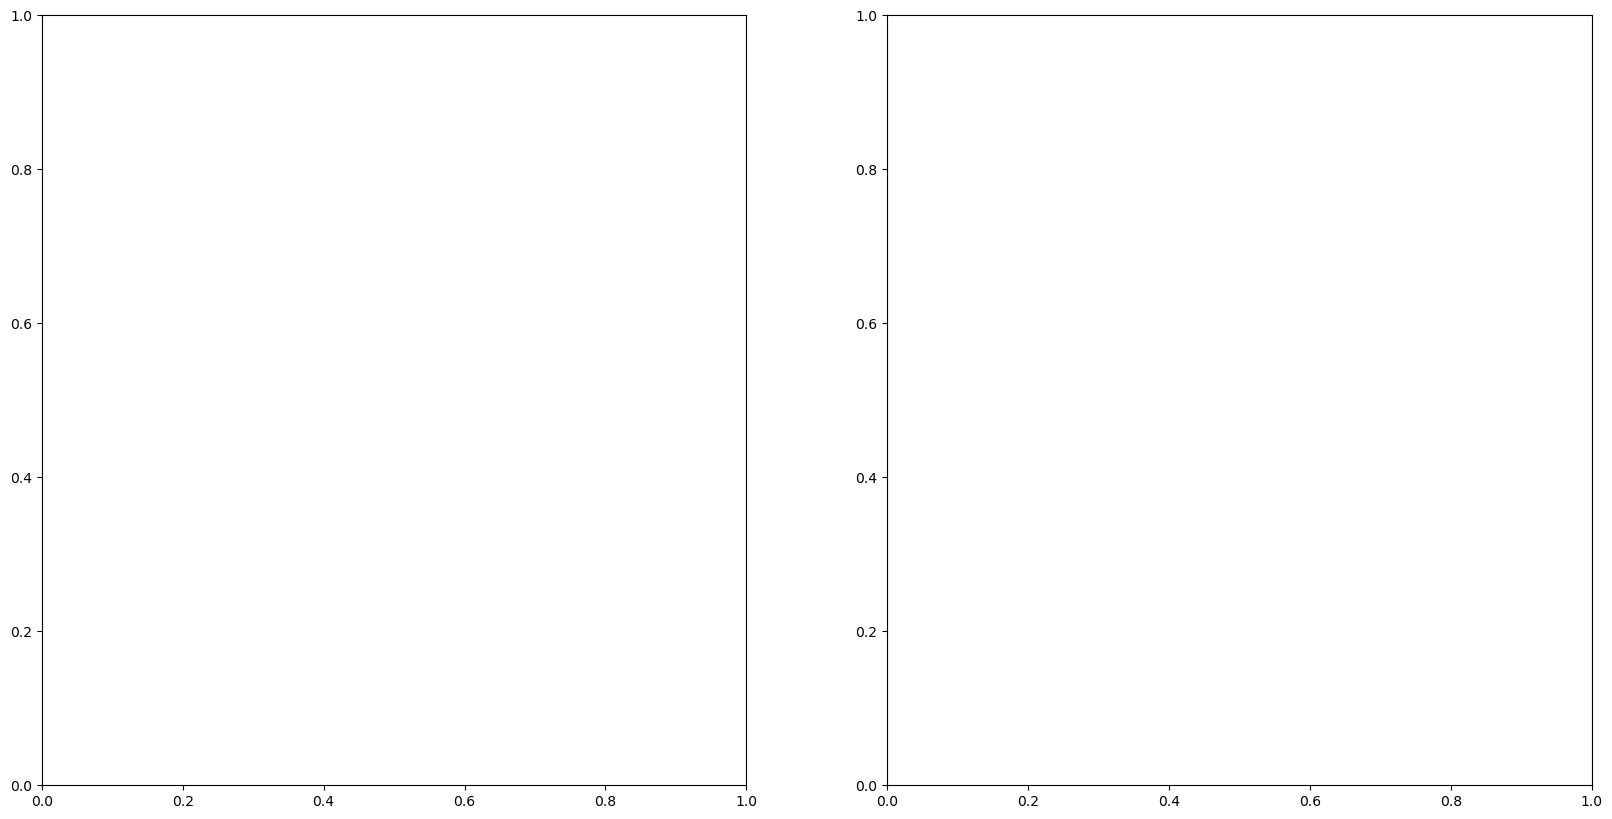

In [28]:
fig, ax_arr = plt.subplots(1, 2, figsize=(20, 10))

ax_arr[0].imshow(CCDData.read(path+'Flats/'+'COG_515151_flats_Blue_04_2022_10_25_16_11_08.fits', unit='adu').data, cmap='gray',vmin=12600, vmax=16800)
ax_arr[0].set_title('Non-saturated Flat')
ax_arr[1].imshow(CCDData.read(path+'Flats/'+'COG_515152_flats_Blue_03_2022_10_25_16_11_35.fits', unit='adu').data, cmap='gray',vmin=64500, vmax=66000)
ax_arr[1].set_title('Saturated Flat')

Before combining the Flats, we will erase the Flats that are not needed. In this case are images: COG_515152_flats_Blue_03_2022_10_25_16_11_35.fits	and COG_515154_flats_Blue_01_2022_10_25_16_15_29.fits.

After this, you can check with the plot before to see if everything is correct.

[13989.0, 8686.0, 11613.0, 27448.0, 28778.0, 8279.0, 26346.0, 28307.0, 26828.0]


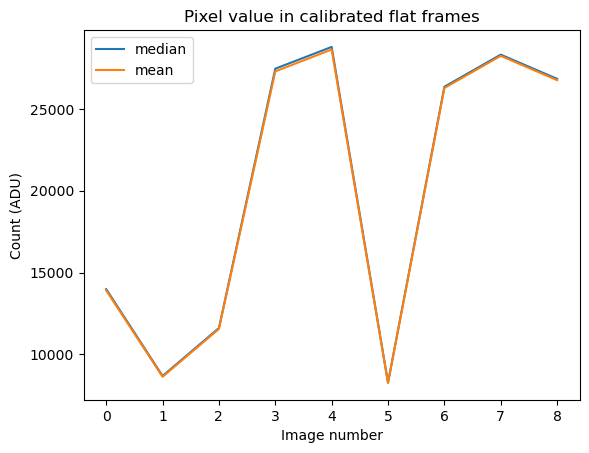

In [33]:
path_Flats = Path(path+'Flats/')
flats_raw = ImageFileCollection(path_Flats)

flats_raw.summary['file', 'imagetyp', 'exptime', 'filter']


median_count = [np.median(data) for data in flats_raw.data(imagetyp='Flat')]
mean_count = [np.mean(data) for data in flats_raw.data(imagetyp='Flat')]
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image number')
plt.ylabel('Count (ADU)')
plt.title('Pixel value in calibrated flat frames')
plt.legend()
print(median_count)

You could also eliminate some images that have very low counts. 

**Now to create the master flats images we first need to subtract the Bias and Dark in each Flat image.**

In [32]:
# Search for the combined bias 
from astropy import units as u

combined_bias = CCDData.read(path+'Bias/'+image_name_bias)
#actual_exposure_times = set(h['exptime'] for h in dark_reduced.headers(imagetyp='Dark', combined=True))
combined_Dark = CCDData.read(path+'Dark_combined/combined_dark.fits')

flats_1 = flats_raw.files_filtered(imagetyp='Flat')
combined_Flat=0

# subtract bias and darks from Flats and save them as Flats_X.fits
for j in range(0,len(flats_1)):
    combined_Flat = CCDData.read(path+'Flats/'+flats_1[j], unit='adu')
    ccd = ccdp.subtract_bias(combined_Flat, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_Dark, exposure_time='exptime', exposure_unit=u.second, scale=True)
    name = 'Flats_{id}.fits'.format(id=j)
    Flat_calcomb = Path(path, 'Flat_combined')  
    Flat_calcomb.mkdir(exist_ok=True) 
    ccd.write(Flat_calcomb / name,overwrite=True)

In [33]:
path_Flats_1 = Path(path+'Flat_combined/')
flats_raw_1 = ImageFileCollection(path_Flats_1)

flats_raw_1.summary['file', 'imagetyp', 'exptime', 'filter']

<Table length=38>
     file     imagetyp exptime filter
    str13       str4   float64  str5 
------------- -------- ------- ------
 Flats_0.fits     Flat    0.05   Blue
 Flats_1.fits     Flat     2.0   Blue
Flats_10.fits     Flat    7.74    Red
Flats_11.fits     Flat    9.37    Red
Flats_12.fits     Flat   10.55    Red
Flats_13.fits     Flat    0.05   Blue
Flats_14.fits     Flat     2.0   Blue
Flats_15.fits     Flat     0.2   Blue
Flats_16.fits     Flat     2.0   Blue
Flats_17.fits     Flat    0.05  Green
          ...      ...     ...    ...
Flats_34.fits     Flat    2.29  Green
Flats_35.fits     Flat    2.01  Green
Flats_36.fits     Flat    0.05   Blue
Flats_37.fits     Flat     2.0   Blue
 Flats_4.fits     Flat    0.05  Green
 Flats_5.fits     Flat     2.0  Green
 Flats_6.fits     Flat    5.51  Green
 Flats_7.fits     Flat    6.41  Green
 Flats_8.fits     Flat    0.05    Red
 Flats_9.fits     Flat     2.0    Red

**Now we need to combine de Flat in each filter**

In [34]:
def inv_median(a):
    return 1 / np.median(a)

In [39]:
# here you can specify the minimum and maximum values allowed for the flat median
# in order to ignore them before combination.
# NOTE: set the variable to None if you already eliminated the problematic flats
exclude_flat_outside_range = (10_000, 45_000)

for filt in flat_filters:
    to_combine = flats_raw_1.files_filtered(imagetyp='Flat', filter=filt, include_path=True)
    if exclude_flat_outside_range is not None:
        data_list = flats_raw_1.data(imagetyp='Flat', filter=filt)
        to_combine_ = []
        for i, (file_path, file_data) in enumerate(zip(to_combine, data_list)):
            median = np.median(file_data)
            if exclude_flat_outside_range[0] < median < exclude_flat_outside_range[1]:
                to_combine_.append(file_path)
            else:
                print(f"Excluding flat {i} in filter {filt} ({file_path}) due to median outside the required range ({median}).")
    else:
        to_combine_ = to_combine
    combined_flat = ccdp.combine(to_combine_, method='average',scale=inv_median, unit='adu')

    combined_flat.meta['combined'] = True
    Flat_file_name = 'combined_flat_filter_{}.fits'.format(filt.replace("''", "p"))
    combined_flat.write(path_Flats_1 / Flat_file_name)

Excluding flat 0 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_17.fits) due to median outside the required range (655.1805).
Excluding flat 1 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_18.fits) due to median outside the required range (6072.55).
Excluding flat 4 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_31.fits) due to median outside the required range (2208.1700000000005).
Excluding flat 9 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_4.fits) due to median outside the required range (1154.68125).


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Excluding flat 1 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_1.fits) due to median outside the required range (64500.96).
Excluding flat 2 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_13.fits) due to median outside the required range (7301.342375).
Excluding flat 3 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_14.fits) due to median outside the required range (64500.560000000005).
Excluding flat 4 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_15.fits) due to median outside the required range (4564.229).
Excluding flat 6 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_2.fits) due to median outside the required range (7652.790999999999).
Excluding flat 7 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_3.fits) due to median outside the required range (63992.14).
Excluding flat 9 (Data/2023_02_XX_M37_original copie/

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Excluding flat 3 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_21.fits) due to median outside the required range (363.126625).
Excluding flat 4 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_22.fits) due to median outside the required range (3362.68).
Excluding flat 8 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_26.fits) due to median outside the required range (1336.34).
Excluding flat 13 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_8.fits) due to median outside the required range (783.3209999999999).
Excluding flat 14 (Data/2023_02_XX_M37_original copie/Flat_combined/Flats_9.fits) due to median outside the required range (7245.18).


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Text(0.5, 1.0, 'Green Flat')

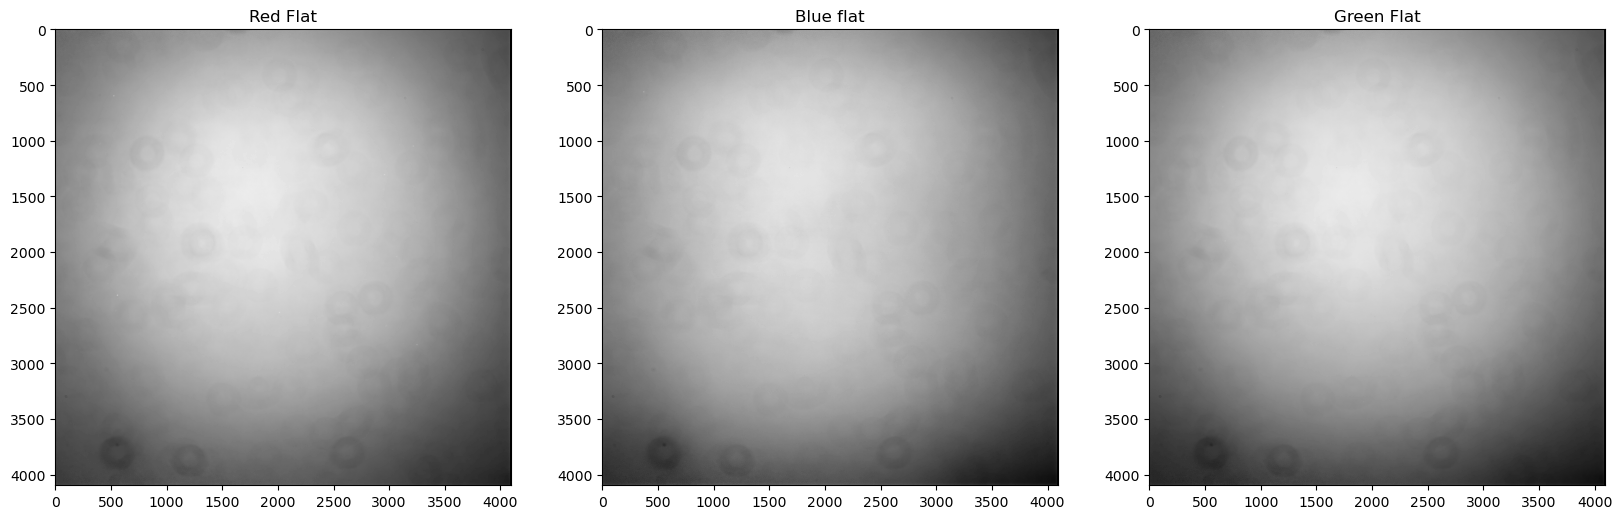

In [40]:
# Plot three Flats

Flat_blue = fits.open(path+'Flat_combined/combined_flat_filter_Blue.fits')
Flat_red = fits.open(path+'Flat_combined/combined_flat_filter_Red.fits')
Flat_green = fits.open(path+'Flat_combined/combined_flat_filter_Green.fits')

fig, ax_arr = plt.subplots(1, 3, figsize=(20, 10))

ax_arr[0].imshow(Flat_red[0].data, cmap='gray',vmin=0.82, vmax=1.11)
ax_arr[0].set_title('Red Flat')
ax_arr[1].imshow(Flat_blue[0].data, cmap='gray',vmin=0.82, vmax=1.11)
ax_arr[1].set_title('Blue flat'.format(len(calibrated_darks)))
ax_arr[2].imshow(Flat_green[0].data, cmap='gray',vmin=0.82, vmax=1.11)
ax_arr[2].set_title('Green Flat')

# Reduction to the science images

First we will move everything we need into a n:

In [41]:
path_img = Path(path, 'Object')  
img_raw = ImageFileCollection(path_img)
img_raw.summary['file', 'imagetyp', 'exptime', 'filter']

<Table length=15>
    file      imagetyp  exptime filter
   str11       str11    float64  str5 
----------- ----------- ------- ------
M37-b1.fits Light Frame    20.0   Blue
M37-b2.fits Light Frame    20.0   Blue
M37-b3.fits Light Frame    20.0   Blue
M37-b4.fits Light Frame    20.0   Blue
M37-b5.fits Light Frame    20.0   Blue
M37-g1.fits Light Frame    20.0  Green
M37-g2.fits Light Frame    20.0  Green
M37-g3.fits Light Frame    20.0  Green
M37-g4.fits Light Frame    20.0  Green
M37-g5.fits Light Frame    20.0  Green
M37-r1.fits Light Frame    20.0    Red
M37-r2.fits Light Frame    20.0    Red
M37-r3.fits Light Frame    20.0    Red
M37-r4.fits Light Frame    20.0    Red
M37-r5.fits Light Frame    20.0    Red

In [44]:
# Search for the combined bias, Dark and Flats
exposure = 'exptime'

combined_bias = CCDData.read(path+'Bias/'+image_name_bias)
combined_Dark = CCDData.read(path+'Dark_combined/combined_dark.fits')
Science_raw = img_raw.files_filtered(imagetyp=science_imagetyp)



reduced_path = path+'Science_combined/'

Subtract bias from science images

In [45]:
# subtract the bias from the science images and save them as Science_X_b.fits

for j in range(0,len(Science_raw)):
    combined_science = CCDData.read(path+'Object/'+Science_raw[j], unit='adu')
    ccd = ccdp.subtract_bias(combined_science, combined_bias)
    name = 'Science_{id}_b.fits'.format(id=j)
    Science_calcomb = Path(path, 'Science_combined')  
    Science_calcomb.mkdir(exist_ok=True) 
    ccd.write(Science_calcomb / name,overwrite=True)

Lets see how the look next to each other:

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Text(0.5, 1.0, 'One science image after Bias')

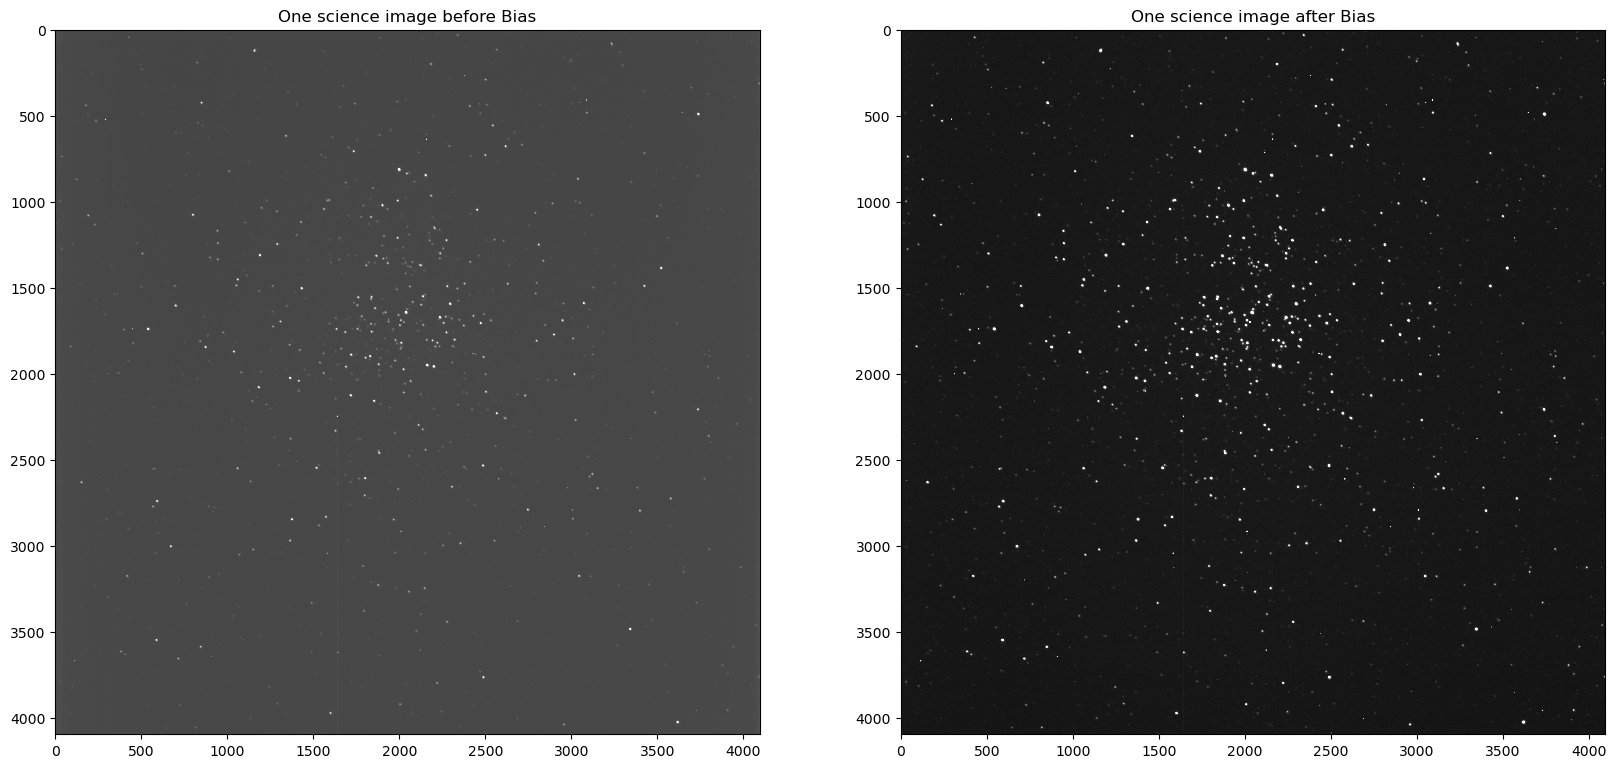

In [46]:
fig, ax_arr = plt.subplots(1, 2, figsize=(20, 10))

if OBJECT_CHOICE == 'M57':
    example_frame_name = 'COG_515173_M57_00_M 57_00__00_2022_10_25_17_30_47.fits'
    norm_before = Normalize(74, 300)
    norm_after = Normalize(0, 1000)

elif OBJECT_CHOICE == 'M27':
    example_frame_name = 'COG_515194_M27_00_M 27_00__00_2022_10_25_18_01_54.fits'
    norm_before = Normalize(1110, 2000)
    norm_after = Normalize(0, 1000)

elif OBJECT_CHOICE == 'M36':
    example_frame_name = 'M36-b1.fits'
    norm_before = LogNorm()
    norm_after = LogNorm()

elif OBJECT_CHOICE == 'M37':
    example_frame_name = 'M37-b1.fits'
    norm_before = Normalize(700, 2000)
    norm_after = Normalize(0, 300)

ax_arr[0].imshow(CCDData.read(path+'Object/'+example_frame_name, unit='adu').data, cmap='gray', norm=norm_before)
ax_arr[0].set_title('One science image before Bias')
ax_arr[1].imshow(CCDData.read(path+'Science_combined/'+'Science_0_b.fits', unit='adu').data, cmap='gray', norm=norm_after)
ax_arr[1].set_title('One science image after Bias')

Subtract Dark from the previous science images

In [47]:
# subtract the Dark from the science images and save them as Science_X_bd.fits

img_b = ImageFileCollection(path+'Science_combined/')
Science_b = img_b.files_filtered(imagetyp=science_imagetyp)

for j in range(0,len(Science_b)):
    combined_science = CCDData.read(path+'Science_combined/'+Science_b[j], unit='adu')
    ccd = ccdp.subtract_dark(combined_science, combined_Dark, exposure_time='exptime', exposure_unit=u.second)
    name = 'Science_{id}_bd.fits'.format(id=j)
    Science_calcomb = Path(path, 'Science_combined')  
    Science_calcomb.mkdir(exist_ok=True) 
    ccd.write(Science_calcomb / name,overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


**Lets see how they look:**

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Text(0.5, 1.0, 'One science image after Dark')

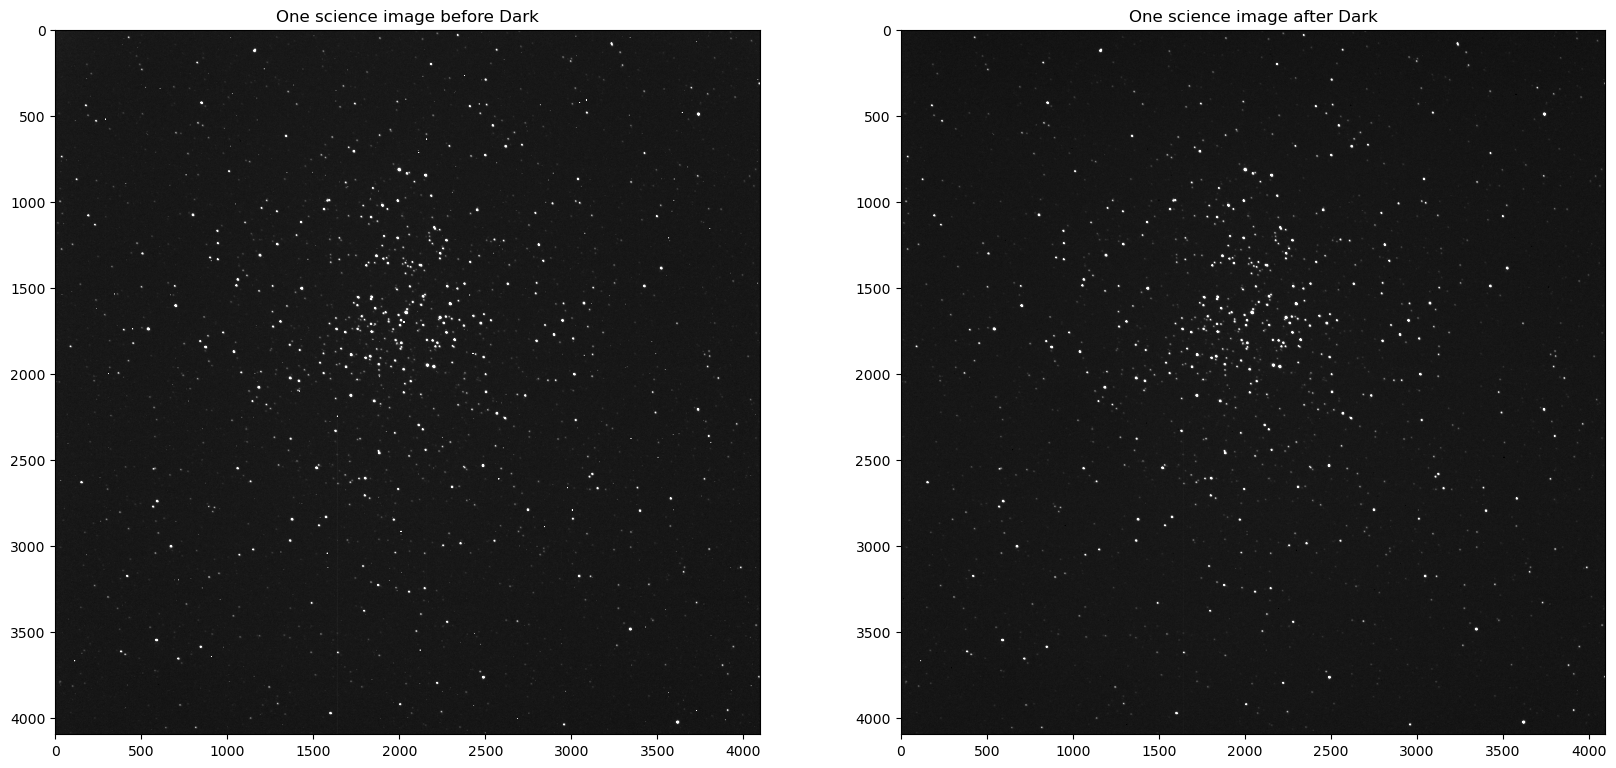

In [48]:
fig, ax_arr = plt.subplots(1, 2, figsize=(20, 10))

ax_arr[0].imshow(CCDData.read(path+'Science_combined/'+'Science_0_b.fits', unit='adu').data, cmap='gray', norm=norm_after)
ax_arr[0].set_title('One science image before Dark')
ax_arr[1].imshow(CCDData.read(path+'Science_combined/'+'Science_0_bd.fits', unit='adu').data, cmap='gray', norm=norm_after)
ax_arr[1].set_title('One science image after Dark')

**Lets divide by the Flats. We have to do this in each filter.**

In [49]:
path_flats=path+'Flat_combined/'
flats_reduced_t = ccdp.ImageFileCollection(path_flats)
combined_flats = {ccd.header['filter']: ccd for ccd in flats_reduced_t.ccds(imagetyp='Flat', combined=True)}

science_bd=ccdp.ImageFileCollection(path+'Science_combined/',glob_include='Science*_bd.fits')

science_bd.summary['file', 'imagetyp', 'exptime', 'filter'] #selected just the ones that are already bias and dark subtracted

<Table length=15>
       file          imagetyp  exptime filter
      str18           str11    float64  str5 
------------------ ----------- ------- ------
 Science_0_bd.fits Light Frame    20.0   Blue
Science_10_bd.fits Light Frame    20.0  Green
Science_11_bd.fits Light Frame    20.0  Green
Science_12_bd.fits Light Frame    20.0  Green
Science_13_bd.fits Light Frame    20.0  Green
Science_14_bd.fits Light Frame    20.0  Green
 Science_1_bd.fits Light Frame    20.0    Red
 Science_2_bd.fits Light Frame    20.0    Red
 Science_3_bd.fits Light Frame    20.0    Red
 Science_4_bd.fits Light Frame    20.0    Red
 Science_5_bd.fits Light Frame    20.0    Red
 Science_6_bd.fits Light Frame    20.0   Blue
 Science_7_bd.fits Light Frame    20.0   Blue
 Science_8_bd.fits Light Frame    20.0   Blue
 Science_9_bd.fits Light Frame    20.0   Blue

In [50]:
# Divide by the Flat and save them as Science_X_bdf.fits

if OBJECT_CHOICE == 'M57':
    ignore_channels = ['Luminance']  # to skip certain types of science frame (e.g. there is no science frame for 'Luminance' channel, along calib frames)
else:
    ignore_channels = []

#all_reds = []
#light_ccds = []
for light, file_name in science_bd.ccds(imagetyp=science_imagetyp, return_fname=True):
    if light.header['filter'] in ignore_channels:
        print(f"INFO: ignoring {light.header['filter']}.")
        continue
    #light_ccds.append(light)
    
    #print(light.header['filter'])
    reduced=light
    good_flat = combined_flats[reduced.header['filter']]
    #print(combined_flats)
    reduced = ccdp.flat_correct(reduced, good_flat)
    #all_reds.append(reduced)
    file=os.path.splitext(file_name)[0]
    name = '{id}f.fits'.format(id=file)
    Science_calcomb = Path(path, 'Science_combined')
    reduced.write(Science_calcomb / name, overwrite=True)

**Lets see how one image look**

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Text(0.5, 1.0, 'One science Blue image after Flat')

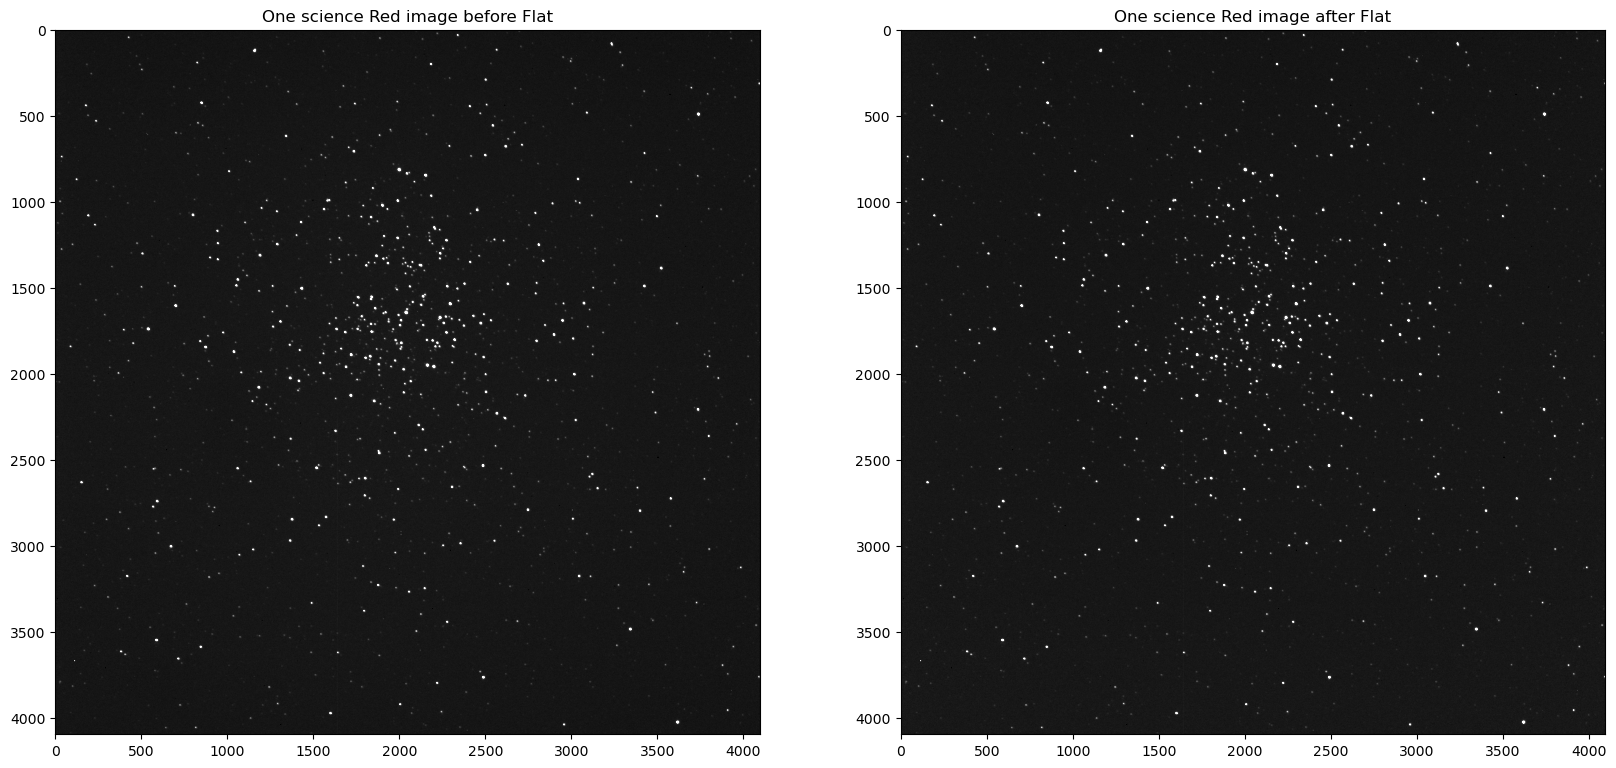

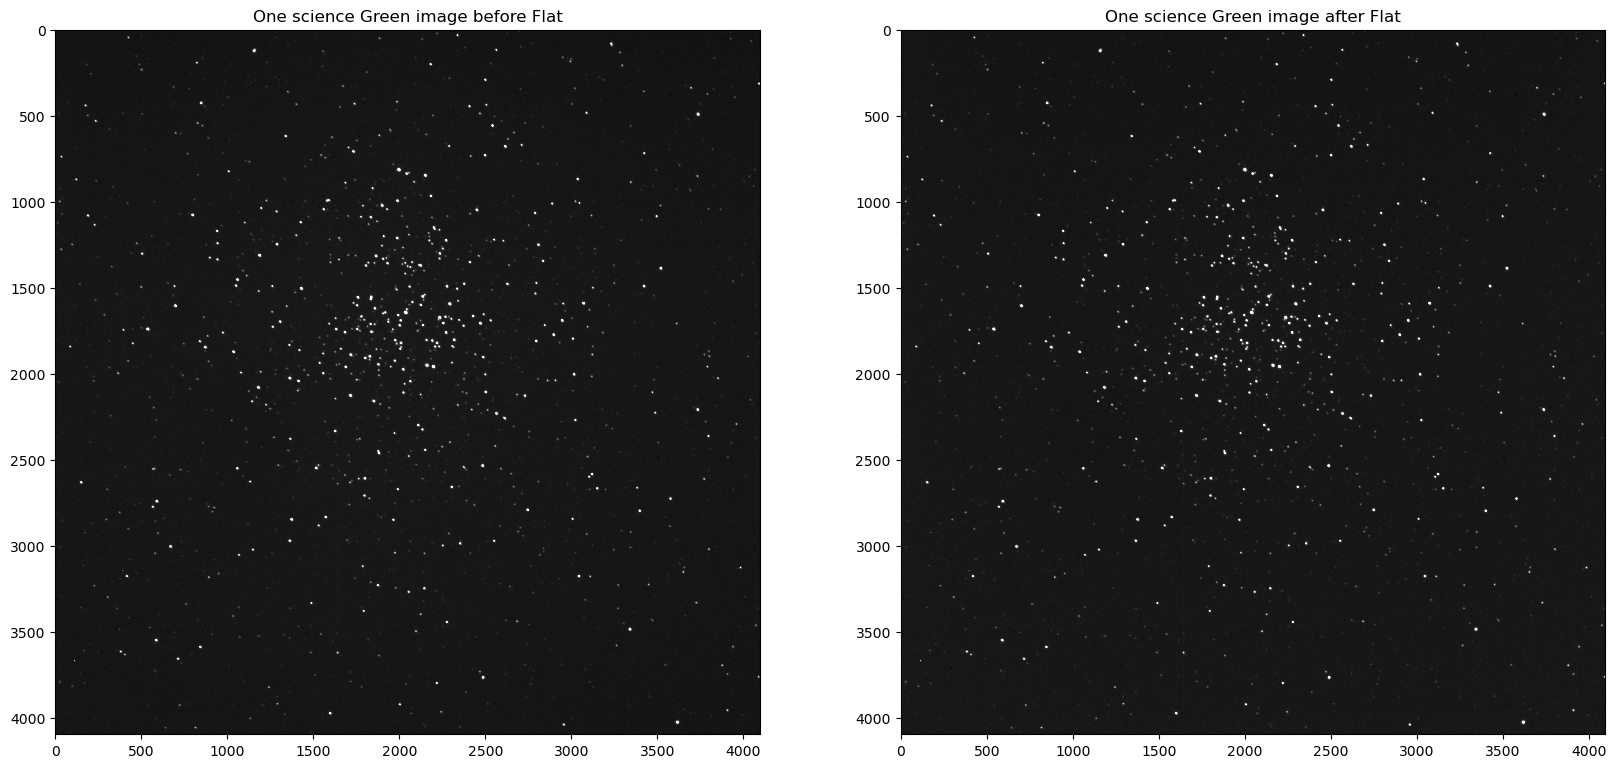

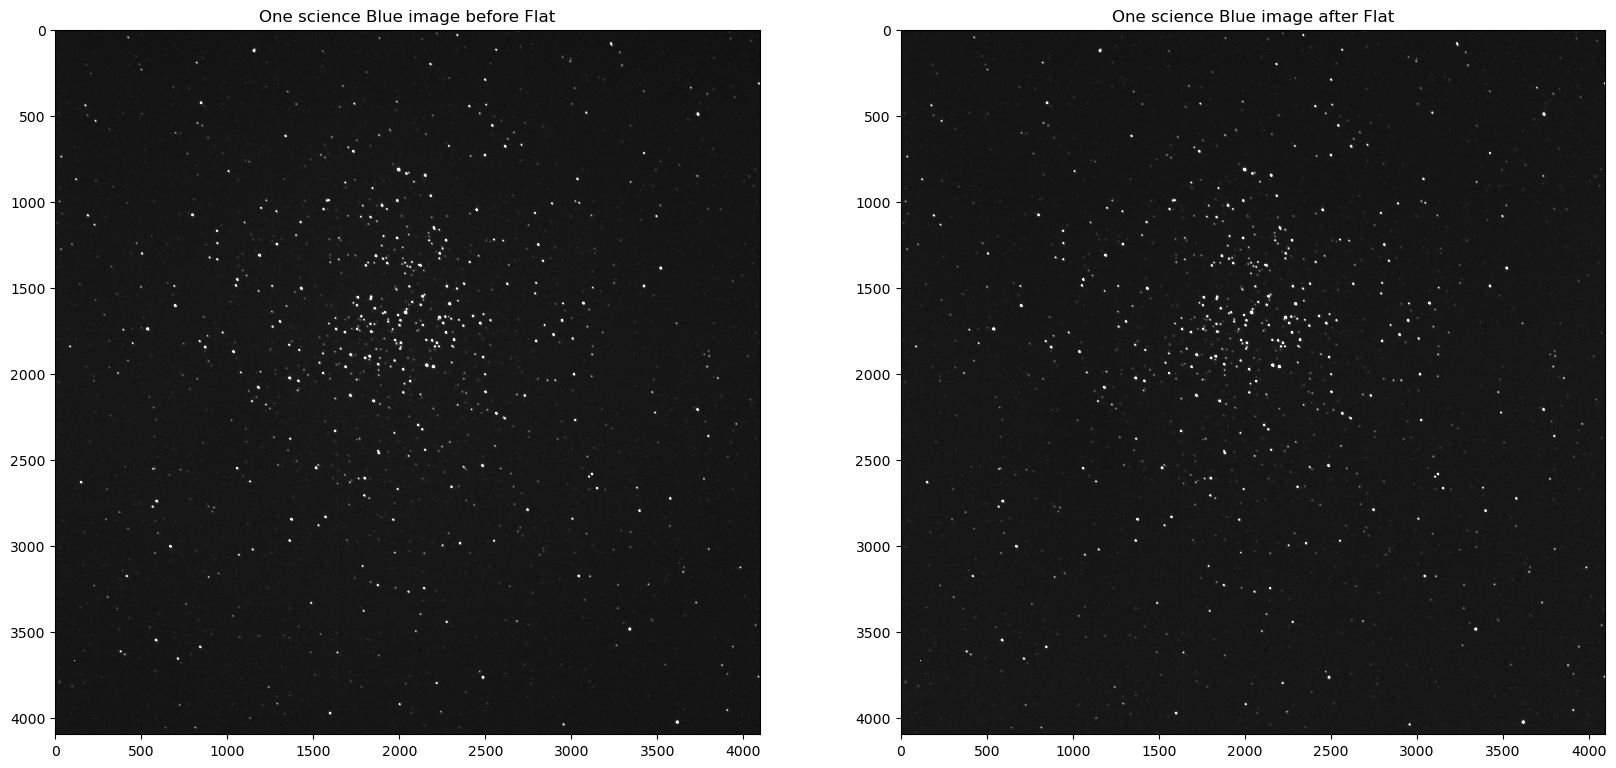

In [51]:
fig, ax_arr = plt.subplots(1, 2, figsize=(20, 10))

ax_arr[0].imshow(CCDData.read(path+'Science_combined/'+'Science_0_bd.fits', unit='adu').data, cmap='gray', norm=norm_after)
ax_arr[0].set_title('One science Red image before Flat')
ax_arr[1].imshow(CCDData.read(path+'Science_combined/'+'Science_0_bdf.fits', unit='adu').data, cmap='gray', norm=norm_after)
ax_arr[1].set_title('One science Red image after Flat')
fig, ax_arr = plt.subplots(1, 2, figsize=(20, 10))
ax_arr[0].imshow(CCDData.read(path+'Science_combined/'+'Science_6_bd.fits', unit='adu').data, cmap='gray', norm=norm_after)
ax_arr[0].set_title('One science Green image before Flat')
ax_arr[1].imshow(CCDData.read(path+'Science_combined/'+'Science_6_bdf.fits', unit='adu').data, cmap='gray', norm=norm_after)
ax_arr[1].set_title('One science Green image after Flat')
fig, ax_arr = plt.subplots(1, 2, figsize=(20, 10))
ax_arr[0].imshow(CCDData.read(path+'Science_combined/'+'Science_9_bd.fits', unit='adu').data, cmap='gray', norm=norm_after)
ax_arr[0].set_title('One science Blue image before Flat')
ax_arr[1].imshow(CCDData.read(path+'Science_combined/'+'Science_9_bdf.fits', unit='adu').data, cmap='gray', norm=norm_after)
ax_arr[1].set_title('One science Blue image after Flat')

# 

# Now we just need to combine each color of the science images

In [52]:
# Things get quite memory heavy here, since everything was loaded before

# It might be useful to reload the notebook here, just to flushs the memory clean. After it has restarted, you can import
# these packages; the scripts below does not use any variables from above.

import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
import os
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

from pathlib import Path
from ccdproc import ImageFileCollection
import ccdproc as ccdp

In [53]:
reduc_path = Path(path+'Science_combined/')

alldata = ImageFileCollection(reduc_path, glob_include='Science*_bdf.fits')
alldata.summary

<Table masked=True length=15>
        file        simple bitpix ... flat_correct            flatcor           
       str19         bool  int64  ...     str7                 str29            
------------------- ------ ------ ... ------------ -----------------------------
 Science_0_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
Science_10_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
Science_11_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
Science_12_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
Science_13_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
Science_14_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
 Science_1_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
 Science_2_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
 Science_3_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
 Science_4_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
 Science_5_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
 Science_6_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
 Science_7_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
 Science_8_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>
 Science_9_bdf.fits   True    -64 ...      flatcor ccd=<CCDData>, flat=<CCDData>

In [54]:
data_red = alldata.files_filtered(filter='Red',include_path=True)
data_blue = alldata.files_filtered(filter='Blue',include_path=True)
data_green = alldata.files_filtered(filter='Green',include_path=True)

In [55]:
data_green

['Data/2023_02_XX_M37_original copie/Science_combined/Science_10_bdf.fits',
 'Data/2023_02_XX_M37_original copie/Science_combined/Science_11_bdf.fits',
 'Data/2023_02_XX_M37_original copie/Science_combined/Science_12_bdf.fits',
 'Data/2023_02_XX_M37_original copie/Science_combined/Science_13_bdf.fits',
 'Data/2023_02_XX_M37_original copie/Science_combined/Science_14_bdf.fits']

In [56]:
#combining red images
combined_red = ccdp.combine(data_red, method='median', unit='adu')
combined_red.meta['combined'] = True
combined_red.write(reduc_path / f'combined_{OBJECT_CHOICE}_Red.fits',overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [57]:
#combining green images
combined_green = ccdp.combine(data_green, method='median', unit='adu')
combined_green.meta['combined'] = True
combined_green.write(reduc_path / f'combined_{OBJECT_CHOICE}_Green.fits',overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [58]:
#combining blue images
combined_blue = ccdp.combine(data_blue, method='median', unit='adu')
combined_blue.meta['combined'] = True
combined_blue.write(reduc_path / f'combined_{OBJECT_CHOICE}_Blue.fits',overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


# See the final images

Text(0.5, 1.0, 'Green image')

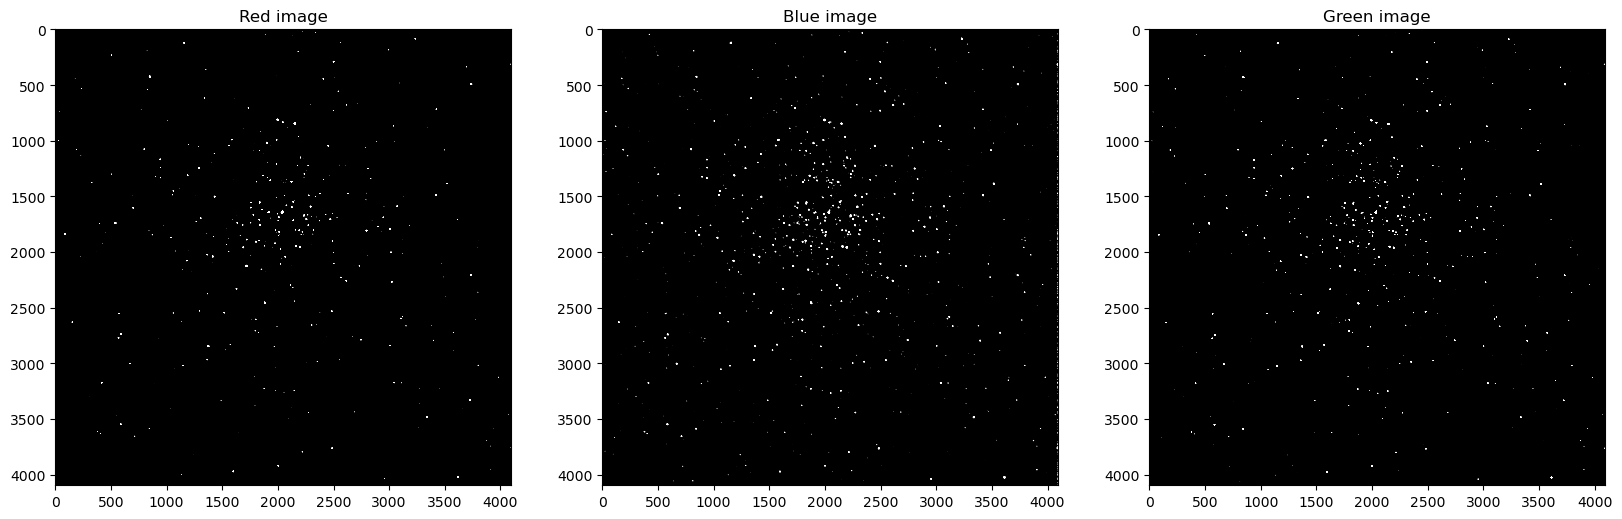

In [59]:
# Plot three Flats

blue = fits.open(path+f'Science_combined/combined_{OBJECT_CHOICE}_Blue.fits')
red = fits.open(path+f'Science_combined/combined_{OBJECT_CHOICE}_Red.fits')
green = fits.open(path+f'Science_combined/combined_{OBJECT_CHOICE}_Green.fits')

fig, ax_arr = plt.subplots(1, 3, figsize=(20, 10))

ax_arr[0].imshow(red[0].data, cmap='gray',vmin=170, vmax=292)
ax_arr[0].set_title('Red image')
ax_arr[1].imshow(blue[0].data, cmap='gray',vmin=46, vmax=152)
ax_arr[1].set_title('Blue image') #.format(len(calibrated_darks)))
ax_arr[2].imshow(green[0].data, cmap='gray',vmin=123, vmax=238)
ax_arr[2].set_title('Green image')

Note: don't worry about those black lines seen in the image, it is a problem of the telescope.

_____________________________

**Important information**

This pipeline is a basic reduction, and it shows you the steps to follow for the reduction of images. The final image could be improved by including different parameters in each step, viewing the images before, and selecting the right ones.

You can modify this pipeline as you like if you want to improve the reduction. You can see in Python what extra parameters can be added to each class.